In [1]:
import os
import keras
keras.__version__
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [3]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [4]:
keras.backend.tensorflow_backend.set_session(get_session())

# Directorios

In [5]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32, 120)


# Modelo InceptionV3

In [8]:
from keras.applications import InceptionV3

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 55,388,312
Trainable params: 55,353,880
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
conv_base.trainable = False

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 55,388,312
Trainable params: 33,585,528
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
if multi_gpu > 1:
    parallel_model = multi_gpu_model(model, gpus=multi_gpu)

# Optimizador

In [15]:
from keras_radam import RAdam

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
                       metrics=['categorical_accuracy'])

# Callbacks

In [16]:
from keras import callbacks

callbacks = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

# Entrenamiento

In [17]:
history = parallel_model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=500,
                                       validation_data=valid_generator,
                                       validation_steps=50,
                                       callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
100/100 [==============================] - 96s 955ms/step - loss: 4.8203 - categorical_accuracy: 0.0300 - val_loss: 3.6999 - val_categorical_accuracy: 0.2662
Epoch 2/500
100/100 [==============================] - 67s 669ms/step - loss: 3.7310 - categorical_accuracy: 0.2181 - val_loss: 1.5638 - val_categorical_accuracy: 0.6126
Epoch 3/500
100/100 [==============================] - 70s 703ms/step - loss: 3.1529 - categorical_accuracy: 0.2997 - val_loss: 1.3306 - val_categorical_accuracy: 0.6569
Epoch 4/500
100/100 [==============================] - 71s 705ms/step - loss: 3.0953 - categorical_accuracy: 0.3003 - val_loss: 1.1989 - val_categorical_accuracy: 0.7009
Epoch 5/500
100/100 [==============================] - 71s 709ms/step - loss: 3.2017 - categorical_accuracy: 0.2850 - val_loss: 1.4573 - val_categorical_accuracy: 0.6162
Epoch 6/500
100/100 [==============================] - 70s 701ms/step - loss: 2.9801 - categorical_acc

100/100 [==============================] - 71s 710ms/step - loss: 1.4752 - categorical_accuracy: 0.5994 - val_loss: 0.4946 - val_categorical_accuracy: 0.8550
Epoch 48/500
100/100 [==============================] - 71s 706ms/step - loss: 1.5535 - categorical_accuracy: 0.5804 - val_loss: 0.5189 - val_categorical_accuracy: 0.8574
Epoch 49/500
100/100 [==============================] - 71s 708ms/step - loss: 1.5534 - categorical_accuracy: 0.5803 - val_loss: 0.5571 - val_categorical_accuracy: 0.8375
Epoch 50/500
100/100 [==============================] - 71s 712ms/step - loss: 1.5054 - categorical_accuracy: 0.5944 - val_loss: 0.4934 - val_categorical_accuracy: 0.8454
Epoch 51/500
100/100 [==============================] - 72s 720ms/step - loss: 1.4464 - categorical_accuracy: 0.6022 - val_loss: 0.5598 - val_categorical_accuracy: 0.8387
Epoch 52/500
100/100 [==============================] - 71s 712ms/step - loss: 1.4807 - categorical_accuracy: 0.5975 - val_loss: 0.5108 - val_categorical_accu

In [31]:
import pickle

# open a file, where you ant to store the data
file = open('./models/history_InceptionV3.pkl', 'wb')

# dump information to that file
pickle.dump(history.history, file)

# close the file
file.close()

# Graficos

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

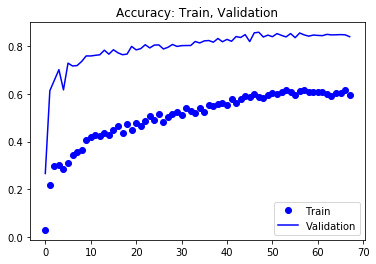

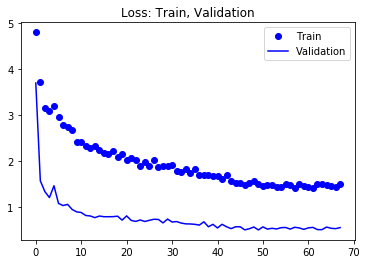

In [33]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [34]:
parallel_model.save('./models/model_InceptionV3_RAdam.h5')

# Predict

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 3025 images belonging to 120 classes.


In [36]:
probabilities = parallel_model.predict_generator(test_generator)

In [37]:
# Get Max Index
predicted_class_index=np.argmax(probabilities,axis=1)

# Dictionary: Index to Class
class_labels = list(test_generator.class_indices.keys())
index_to_labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Get List of Predictions
predictions = [index_to_labels[ix] for ix in predicted_class_index]

# Get Dictionary of Predictions
results=pd.DataFrame({"Filename":test_generator.filenames,
                      "Predictions":predictions})

In [38]:
results.head()

,Filename,Predictions
0,n02085620-Chihuahua\n02085620_10074.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua\n02085620_10131.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua\n02085620_10621.jpg,n02087046-toy_terrier
3,n02085620-Chihuahua\n02085620_1073.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua\n02085620_10976.jpg,n02085620-Chihuahua


In [39]:
results.to_csv("./models/results_details_InceptionV3.csv", sep="|", index=False)

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class_index)

In [41]:
results_dict = {}
tp_sum, fp_sum =0, 0

for ix, row in enumerate(cm):
    
    tp = row[ix]
    fp = np.sum(row) - tp   
    results_dict[ix] = [class_labels[ix],tp,fp,(tp/(tp+fp)*100)]

    tp_sum += tp
    fp_sum += fp
    
df_res = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Class","True Positive","False Positive","Accuracy"])

print("General Accuracy:{:0.2f}".format(tp_sum/(tp_sum+fp_sum)))

General Accuracy:0.84


In [42]:
df_res.head()

,Class,True Positive,False Positive,Accuracy
0,n02085620-Chihuahua,20,2,90.909091
1,n02085782-Japanese_spaniel,26,1,96.296296
2,n02085936-Maltese_dog,35,2,94.594595
3,n02086079-Pekinese,21,1,95.454545
4,n02086240-Shih-Tzu,25,7,78.125000


In [43]:
df_res.to_csv("./models/results_InceptionV3.csv", sep="|", index=False)